Camera Calibration
===

In [ ]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

In [ ]:
# prepare object points
objp = np.zeros((6*9,3),np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store points and image points from all the iamges
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx,fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray,(9,6),None)
    
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # Draw and display the corners
        cv2.drawChessboardCorners(img,(9,6),corners,ret)
        
        cv2.imshow('img',img)
        cv2.waitKey(500)

cv2.destroyAllWindows()

In [ ]:
img_size = (img.shape[1],img.shape[0])
# Do camera calibration given object points and image points
ret,mtx,dist,rvecs,tvecs = cv2.calibrateCamera(objpoints,imgpoints,img_size,None,None)

Distortion Correction
===

In [ ]:
%matplotlib inline

In [ ]:
# Test distortion on an image
img = cv2.imread('./camera_cal/calibration1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
dst = cv2.undistort(img,mtx,dist,None,mtx)

#Visualize undistortion
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image',fontsize = 30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image',fontsize = 30)

In [ ]:
# Test undistortion on an image
img = cv2.imread('./test_images/straight_lines1.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
dst = cv2.undistort(img,mtx,dist,None,mtx)

#Visualize the undistortion
f,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
ax1.imshow(img)
ax1.set_title('Original Image',fontsize = 30)
ax2.imshow(dst)
ax2.set_title('Undistorted Image',fontsize = 30)

Perspective Tramsform
===

In [ ]:
# Define the vertices of a triangular mask
# MODIFY THESE VALUES TO ISOLATE THE REGION WHERE THE LANE LINES ARE IN THE IMAGE
left_bottom = [200, 720]
left_up = [595, 450]
right_bottom = [1120, 720]
right_up = [690, 450]

# Perform a linear fit (y = Ax + B) to each of the three sides of the triangle 
fit_left = np.polyfit((left_bottom[0],left_up[0]),(left_bottom[1],left_up[1]),1)
fit_right = np.polyfit((right_bottom[0],right_up[0]),(right_bottom[1],right_up[1]),1)

# Display the image and show region and color selections
plt.imshow(dst)
x = [left_bottom[0],left_up[0],right_up[0],right_bottom[0]]
y = [left_bottom[1],left_up[1],right_up[1],right_bottom[1]]
plt.plot(x,y,'r-',lw = 1)

In [ ]:
vertices = np.array([[(200,720),(595, 450), (690,450), (1120, 720)]], dtype=np.int32)
mask = np.zeros_like(img)

#defining a 3 channel or 1 channel color to fill the mask with depending on the input image
if len(img.shape) > 2:
    channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
    ignore_mask_color = (255,) * channel_count
else:
    ignore_mask_color = 255
        
#filling pixels inside the polygon defined by "vertices" with the fill color    
cv2.fillPoly(mask, vertices, ignore_mask_color)

# return the image only where mask pixels are nonzero
masked_dst = cv2.bitwise_and(dst, mask)
plt.imshow(masked_dst)

In [ ]:
src = np.float32([[595, 450], [690, 450], 
                  [200, 720], 
                  [1120, 720]])
dst = np.float32([[405,0],[905,0],[405,720],[905,720]])
M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(dst,src)
bird_eye = cv2.warpPerspective(masked_dst,M,(img.shape[1],img.shape[0]),flags = cv2.INTER_LINEAR)

f,(ax1,ax2) = plt.subplots(1,2,figsize = (20,10))
ax1.imshow(img)
ax1.set_title('Original Image',fontsize = 50)
ax2.imshow(bird_eye)
ax2.set_title('Bird-eye View',fontsize = 50)
#plt.subplots_adjust(left = 0,right = 1,top = 0.9,bottom = 0.)

In [ ]:
import pickle
# Save the camera calibration result for later use
dist_pickle={}
dist_pickle['mtx'] = mtx
dist_pickle['dist'] = dist
dist_pickle['M'] = M
dist_pickle['Minv'] = Minv
pickle.dump(dist_pickle,open('./test_images/dist_pickle.p','wb'))

Check Point
===

In [1]:
import matplotlib.pyplot as plt
import cv2
import pickle
import numpy as np
import matplotlib.image as mpimg
%matplotlib inline

dist_pickle = pickle.load( open( "./test_images/dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
M = dist_pickle["M"]
Minv = dist_pickle["Minv"]
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/500 # meters per pixel in x dimension

Color and Gradient Threshold
===

In [2]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

def pipeline(img,sobel_kernel = 5,l_threshold = (200,255),s_thresh = (150,255),sx_thresh = (50,155), dir_thresh = (np.pi/18*3,np.pi/18*7)):
    # Convert to HSL color space
    hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    #Take the gradient in x and y seperately
    sobelx = cv2.Sobel(l_channel,cv2.CV_64F,1,0,ksize = sobel_kernel)# Take the derivative in x
    sobely = cv2.Sobel(l_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel) # Take the derivative in y
    # Calculate the magnitude
    sobel_mag = np.sqrt(sobelx**2,sobely**2)
    # Scale to 8-bit (0 -255) and convert to type = np.unit8
    sobel_scaled = np.uint8(sobel_mag/np.max(sobel_mag)*255)
    
    # Threshold x gradient
    binary_mag = np.zeros_like(sobel_scaled)
    binary_mag[(sobel_scaled >= sx_thresh[0])&(sobel_scaled <= sx_thresh[1])]=1
    binary_s = np.zeros_like(sobel_scaled)
    binary_s[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    binary_l = np.zeros_like(sobel_scaled)
    binary_l[(l_channel >= l_threshold[0]) & (l_channel <= l_threshold[1])] = 1    
    binary = (binary_s | binary_mag | binary_l)
    
    sobelx = cv2.Sobel(binary,cv2.CV_64F,1,0,ksize = sobel_kernel)
    sobely = cv2.Sobel(binary,cv2.CV_64F,0,1,ksize = sobel_kernel)
    sobel_dir = np.arctan2(np.absolute(sobely),np.absolute(sobelx))
    binary_dir = np.zeros_like(sobel_scaled)
    binary_dir[(sobel_dir >= dir_thresh[0]) & (sobel_dir <= dir_thresh[1])] = 1
    
    
    
    return binary_dir

In [3]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

def perspectiveTransform(img):
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

Detect Lane Pixels and Find Lane Lines
===

In [4]:
def fitByWindow(warped, window_width, window_height, margin, minpix=50):
    
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    # Store the (left,right) window centroid positions per level
    window_centroids = []
    # Create our window template that we will use for convolutions
    window = np.ones(window_width) 
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    leftx_base = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    rightx_base = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base    
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
        
    # Go through each layer looking for max pixel locations
    for level in range((int)(warped.shape[0]/window_height)):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = int(warped.shape[0] - (level+1)*window_height)
        win_y_high = int(warped.shape[0] - level*window_height)
        win_xleft_low = int(leftx_current - margin)
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)        
        # convolve the window into the vertical slice of the image
        image_layer = np.sum(warped[win_y_low:win_y_high,:], axis=0)
        conv_signal = np.convolve(window, image_layer)
        # Find the best left centroid by using past left center as a reference
        # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
        offset = window_width/2
        l_min_index = int(max(win_xleft_low+offset,0))
        l_max_index = int(min(win_xleft_high+offset,warped.shape[1]))
        l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
        # Find the best right centroid by using past right center as a reference
        r_min_index = int(max(win_xright_low+offset,0))
        r_max_index = int(min(win_xright_high+offset,warped.shape[1]))
        r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = l_center
        if len(good_right_inds) > minpix:  
            rightx_current = r_center                
        # Draw the windows on the visualization image
        win_y_low = int(warped.shape[0] - (level+1)*window_height)
        win_y_high = int(warped.shape[0] - level*window_height)
        win_xleft_low = int(leftx_current - margin)
        win_xleft_high = int(leftx_current + margin)
        win_xright_low = int(rightx_current - margin)
        win_xright_high = int(rightx_current + margin)
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2)
        # Add what we found for that layer
        window_centroids.append((leftx_current, rightx_current)) 
    
    left_fit = []
    right_fit = []
    left_curverad = None
    right_curverad = None
    left_fitx = []
    right_fitx = []
    # Concatenate the arrays of indices
    # Extract left and right line pixel positions
    # Fit a second order polynomial to each
    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    if np.sum(left_lane_inds)>2:        
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        left_fit = np.polyfit(lefty, leftx, 2)
        left_curverad = ((1 + xm_per_pix/ ym_per_pix*(2*left_fit[0]*720 + left_fit[1])**2)**1.5) / np.absolute((xm_per_pix/ ym_per_pix**2)*2*left_fit[0])
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        #left_fit = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
        #left_curverad = ((1 + (2*left_fit[0]*720*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
        #print(left_curverad)
        
    if np.sum(right_lane_inds)>2:        
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        right_fit = np.polyfit(righty, rightx, 2)
        right_curverad = ((1 + xm_per_pix/ ym_per_pix*(2*right_fit[0]*720 + right_fit[1])**2)**1.5) / np.absolute((xm_per_pix/ ym_per_pix**2)*2*right_fit[0])
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    
    if False:
        # Generate x and y values for plotting
        print(left_curverad)
        print(right_curverad)
        plt.figure()
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
    
    return out_img, left_fit, right_fit, left_curverad, right_curverad, left_fitx, right_fitx, ploty

In [5]:
def fitAroundPrevious(warped,left_fit,right_fit,margin = 50):
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])  
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    left_fit_new = []
    right_fit_new = []    
    ploty = np.linspace(0, warped.shape[0]-1, warped.shape[0] )
    left_curverad = None
    right_curverad = None
    left_fitx = []
    right_fitx = []
    # Again, extract left and right line pixel positions
    # Fit a second order polynomial to each
    if np.sum(left_lane_inds)>2:
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds]
        left_fit_new = np.polyfit(lefty, leftx, 2)
        left_fitx = left_fit_new[0]*ploty**2 + left_fit_new[1]*ploty + left_fit_new[2]
        left_curverad = ((1 + xm_per_pix/ ym_per_pix*(2*left_fit_new[0]*720 + left_fit_new[1])**2)**1.5) / np.absolute((xm_per_pix/ ym_per_pix**2)*2*left_fit_new[0])
        
    if np.sum(right_lane_inds)>2:
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        right_fit_new = np.polyfit(righty, rightx, 2)
        right_fitx = right_fit_new[0]*ploty**2 + right_fit_new[1]*ploty + right_fit_new[2]   
        right_curverad = ((1 + xm_per_pix/ ym_per_pix*(2*right_fit_new[0]*720 + right_fit_new[1])**2)**1.5) / np.absolute((xm_per_pix/ ym_per_pix**2)*2*right_fit_new[0])
        
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((warped, warped, warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    if False:
        print(left_curverad)
        print(right_curverad)  
        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))
        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        window_img = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.figure()
        plt.imshow(window_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
  
    return out_img, left_fit_new, right_fit_new, left_curverad, right_curverad, left_fitx, right_fitx, ploty    

Deternmine the curverad and vehicle position with respect to center
===

In [6]:
def curve_line(fit, shape=720):
    ploty = np.linspace(0, shape-1, shape )
    curverad = ((1 + xm_per_pix/ ym_per_pix*(2*fit[0]*720 + fit[1])**2)**1.5) / np.absolute((xm_per_pix/ ym_per_pix**2)*2*fit[0])
    fitx = fit[0]*ploty**2 + fit[1]*ploty + fit[2]
    
    return curverad, fitx, ploty    

Warp the detected lane image back to the original image
===

In [7]:
def draw_lane(undist,warped, left_fitx, right_fitx, ploty, weight=0.3):
    # Create an image to draw the lines on
    #warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.zeros_like(warped).astype(np.uint8)
    
    if len(left_fitx)>0 and len(right_fitx)>0:
        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
        pts = np.hstack((pts_left, pts_right))
        #print(np.int_([pts]).shape)
        #Draw the lane onto the warped blank image  
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0)) 
        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(undist, 1, newwarp, weight, 0)
    else:
        result = undist            
    
    if False:
        plt.figure()
        plt.imshow(result)
        
    return result

In [8]:
def to_pic(binary_masked):
    return np.dstack((binary_masked*255,binary_masked*255,binary_masked*255)).astype(np.uint8)

In [9]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None   
        #polynomial coefficients for the last n fit
        self.recent_fit = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None

In [10]:
num_average = 1
num_shack = 1
def process_image(image):
    undist = undistort(image)
    #hls_binary = hls_select(undist, thresh=(100, 255))
    binary = pipeline(image)
    vertices = np.array([[(100,720),(500, 450), (780,450), (1200, 720)]], dtype=np.int32)
    binary_masked = region_of_interest(binary, vertices)
    
    top_down = perspectiveTransform(binary_masked)    
    
    if (line_left.detected == True) and (line_right.detected == True):
        out_img_line, left_fit, right_fit, left_curve, right_curve, left_fitx, right_fitx, ploty = fitAroundPrevious(top_down, line_left.recent_fit[-1], line_right.recent_fit[-1], margin = 25)
    else:
        out_img_line, left_fit, right_fit, left_curve, right_curve, left_fitx, right_fitx, ploty = fitByWindow(top_down, window_width = 25 , window_height = 80, margin = 25)
   
    line_left.detected = False
    if len(left_fit)>0:
        if line_left.bestx is not None:
            if np.mean(np.abs(line_left.bestx-left_fitx))<20:
                line_left.detected = True
        else:
            line_left.detected = True  
    if line_left.detected == True:       
        if len(line_left.recent_xfitted)>=num_average:
            line_left.recent_xfitted.pop(0)
            line_left.recent_fit.pop(0)
        line_left.recent_xfitted.append(left_fitx)
        line_left.recent_fit.append(left_fit)   
    else:
        if len(line_left.recent_xfitted)>0:
            line_left.recent_xfitted.pop(0)
            line_left.recent_fit.pop(0)
    if len(line_left.recent_xfitted)>0:        
        line_left.bestx = np.mean(line_left.recent_xfitted, axis=0)
        line_left.best_fit = np.mean(line_left.recent_fit, axis=0) 
    else:
        line_left.bestx = None
        line_left.best_fit = None    
    if len(line_left.recent_xfitted)>=num_shack:
        curvature, fitx, ploty = curve_line(line_left.recent_fit[-1])
        line_left.radius_of_curvature = curvature 
        line_left.allx = fitx 
        line_left.ally = ploty        
        line_left.line_base_pos = (640-fitx[-1])*xm_per_pix      
        
    line_right.detected = False
    if len(right_fit)>0:
        if line_right.bestx is not None:
            if np.mean(np.abs(line_right.bestx-right_fitx))<20:
                line_right.detected = True
        else:
            line_right.detected = True  
    if line_right.detected == True:       
        if len(line_right.recent_xfitted)>=num_average:
            line_right.recent_xfitted.pop(0)
            line_right.recent_fit.pop(0)
        line_right.recent_xfitted.append(right_fitx)
        line_right.recent_fit.append(right_fit)   
    else:
        if len(line_right.recent_xfitted)>0:
            line_right.recent_xfitted.pop(0)
            line_right.recent_fit.pop(0)
    if len(line_right.recent_xfitted)>0:        
        line_right.bestx = np.mean(line_right.recent_xfitted, axis=0)
        line_right.best_fit = np.mean(line_right.recent_fit, axis=0)  
    else:
        line_right.bestx = None
        line_right.best_fit = None    
    if len(line_right.recent_xfitted)>=num_shack:
        curvature, fitx, ploty = curve_line(line_right.recent_fit[-1])
        line_right.radius_of_curvature = curvature 
        line_right.allx = fitx 
        line_right.ally = ploty        
        line_right.line_base_pos = (640-fitx[-1])*xm_per_pix    
           
    if (len(line_left.recent_xfitted)>=num_shack) and (len(line_right.recent_xfitted)>=num_shack):
        out_img = draw_lane(undist,out_img_line, line_left.allx, line_right.allx, ploty)
        curvature = 'Radius of curvature = '+str(int((line_left.radius_of_curvature+line_right.radius_of_curvature)/2))+'(m)'
        pos = 'Vehicle is '+str(round((line_left.line_base_pos+line_right.line_base_pos)/2, 2))+'m from center'
        cv2.putText(out_img, curvature,(100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0),8,cv2.LINE_AA)
        cv2.putText(out_img, pos,(100,200), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0),8,cv2.LINE_AA)        
    elif (len(line_left.recent_xfitted)<num_shack) and (len(line_right.recent_xfitted)>=num_shack):
        out_img = draw_lane(undist,out_img_line, line_right.allx-500, line_right.allx, ploty)
        curvature = 'Radius of curvature = '+str(int(line_right.radius_of_curvature))+'(m)'
        pos = 'Vehicle is '+str(round(line_right.line_base_pos, 2))+'m from center'
        cv2.putText(out_img, curvature,(100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0),8,cv2.LINE_AA)
        cv2.putText(out_img, pos,(100,200), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0),8,cv2.LINE_AA)  
    elif (len(line_left.recent_xfitted)>=num_shack) and (len(line_right.recent_xfitted)<num_shack):
        out_img = draw_lane(undist,out_img_line, line_left.allx, line_left.allx+500, ploty)
        curvature = 'Radius of curvature = '+str(int(line_left.radius_of_curvature))+'(m)'
        pos = 'Vehicle is '+str(round(line_left.line_base_pos, 2))+'m from center'
        cv2.putText(out_img, curvature,(100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0),8,cv2.LINE_AA)
        cv2.putText(out_img, pos,(100,200), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,0,0),8,cv2.LINE_AA)  
    else:
        out_img = undist     
    
    return out_img

Video Output
===

In [ ]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
line_left = Line()
line_right = Line()
white_output = 'challenge_result_V2.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

TEST IMAGE
===

Wall time: 268 ms


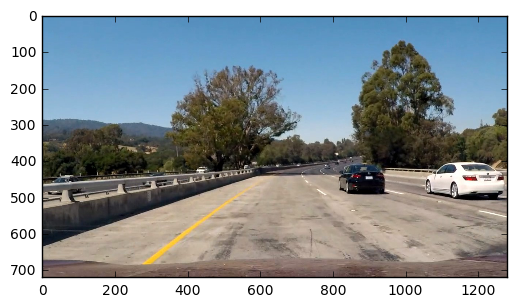

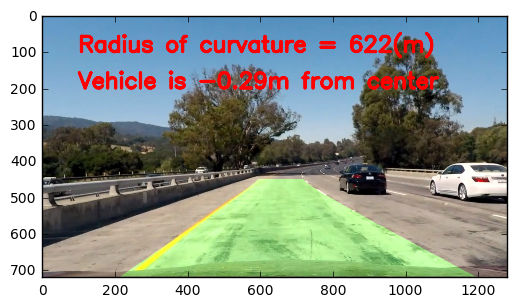

In [17]:
line_left = Line()
line_right = Line()
img = cv2.imread('test_images/test7.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
%time test = process_image(img)
plt.figure()
plt.imshow(img)
plt.figure()
plt.imshow(test)

CODING EXE
===

Wall time: 973 µs


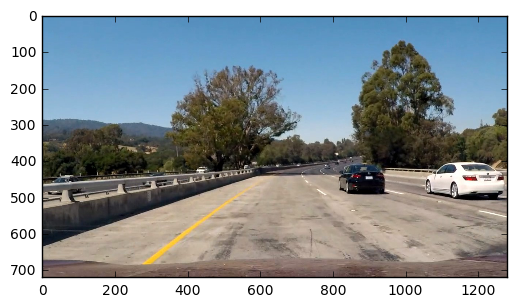

In [18]:
image = cv2.imread('./test_images/test7.jpg')
%time image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
plt.imshow(image)

In [19]:
%time image_undistorted = undistort(image)

Wall time: 66.2 ms


Wall time: 157 ms


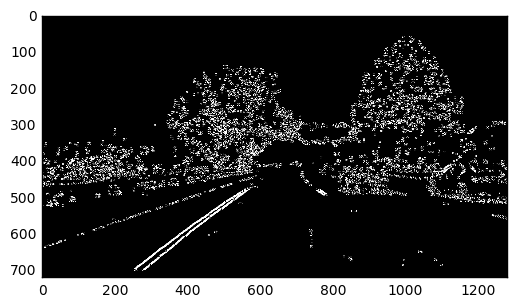

In [20]:
%time binary = pipeline(image_undistorted)
plt.imshow(binary,cmap='gray')

In [21]:
vertices = np.array([[(100,720),(500, 450), (780,450), (1200, 720)]], dtype=np.int32)
%time binary_masked = region_of_interest(binary, vertices)

Wall time: 973 µs


In [22]:
%time top_down = perspectiveTransform(binary_masked) 

Wall time: 5.01 ms


In [ ]:
plt.imshow(top_down,cmap='gray')

In [23]:
window_width = 50
window_height = 80 
margin = 100
minpix=50
# Create an output image to draw on and  visualize the result
out_img = np.dstack((top_down, top_down, top_down))*255
# Store the (left,right) window centroid positions per level
window_centroids = []
# Create our window template that we will use for convolutions
window = np.ones(window_width) 
    
# Identify the x and y positions of all nonzero pixels in the image
nonzero = top_down.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])


In [ ]:
l_sum = np.sum(binary[int(3*top_down.shape[0]/4):,:int(top_down.shape[1]/2)], axis=0)
leftx_base = np.argmax(np.convolve(window,l_sum))-window_width/2

In [24]:
%time [out_img, left_fit, right_fit, left_curverad, right_curverad, left_fitx, right_fitx, ploty] = fitByWindow(top_down, window_width = 25 , window_height = 80, margin = 100)

Wall time: 40.1 ms


In [ ]:
#plt.figure()
#plt.plot(left_fitx,ploty)
plt.imshow(out_img)

In [ ]:
plt.figure()
plt.plot(left_fitx,ploty)
plt.plot(right_fitx,ploty)
plt.imshow(out_img)

In [25]:
%time lane_image =  draw_lane(image_undistorted,out_img, left_fitx, right_fitx, ploty, weight=0.3)

Wall time: 15 ms


In [ ]:
plt.imshow(lane_image)

In [26]:
%time newwarp = cv2.warpPerspective(out_img, Minv, (image_undistorted.shape[1], image_undistorted.shape[0]))

Wall time: 6.99 ms


In [ ]:
plt.imshow(newwarp)

In [ ]:
if len(left_fitx)>0 and len(right_fitx)>0:
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    #print(np.int_([pts]).shape)
    #Draw the lane onto the warped blank image  
    cv2.fillPoly(out_img, np.int_([pts]), (0,255, 0)) 
    newwarp = cv2.warpPerspective(out_img, Minv, (image_undistorted.shape[1], image_undistorted.shape[0])) 

In [ ]:
hls = cv2.cvtColor(image,cv2.COLOR_BGR2HLS).astype(np.float)

In [ ]:
plt.imshow(hls[:,:,0],cmap='gray')

In [ ]:
plt.imshow(hls[:,:,1],cmap='gray')

In [ ]:
threshold_l = [200,255]
binary_l = np.zeros_like(hls[:,:,1])
binary_l[(hls[:,:,1] >= threshold_l[0]) & (hls[:,:,1] <= threshold_l[1])] = 1
plt.imshow(binary_l,cmap='gray')

In [ ]:
plt.imshow(hls[:,:,2],cmap='gray')

In [ ]:
binary_pipe = pipeline(image)

In [ ]:
plt.imshow(binary_pipe,cmap='gray')